In [1]:
import pandas as pd

train_path = "Titanic_train.csv"
test_path  = "Titanic_test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print(f"Train shape : {train_df.shape}")
print(f"Test  shape : {test_df.shape}")
train_df.head()


Train shape : (891, 12)
Test  shape : (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# Data types & missing values
train_df.info()

# Numerical summary
train_df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


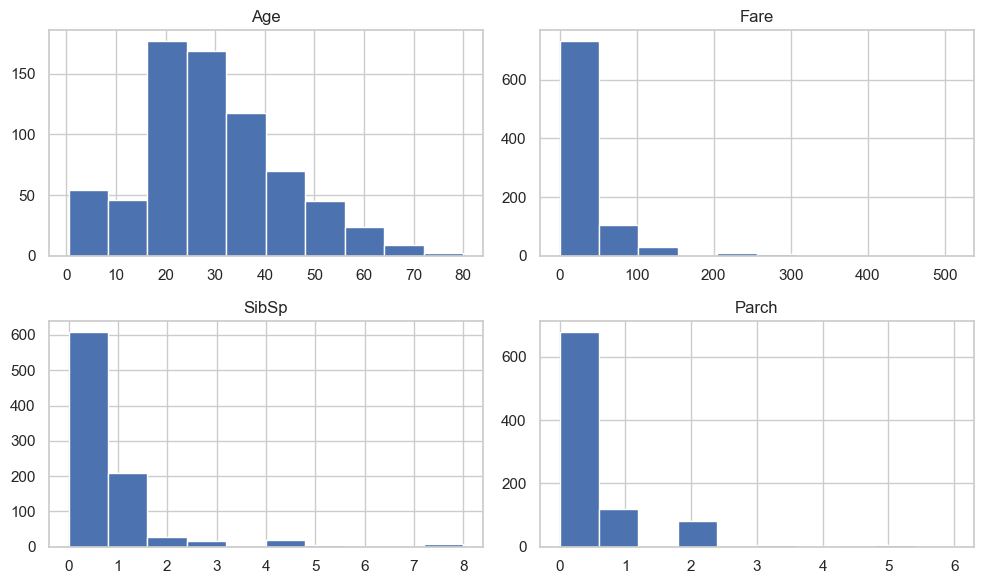

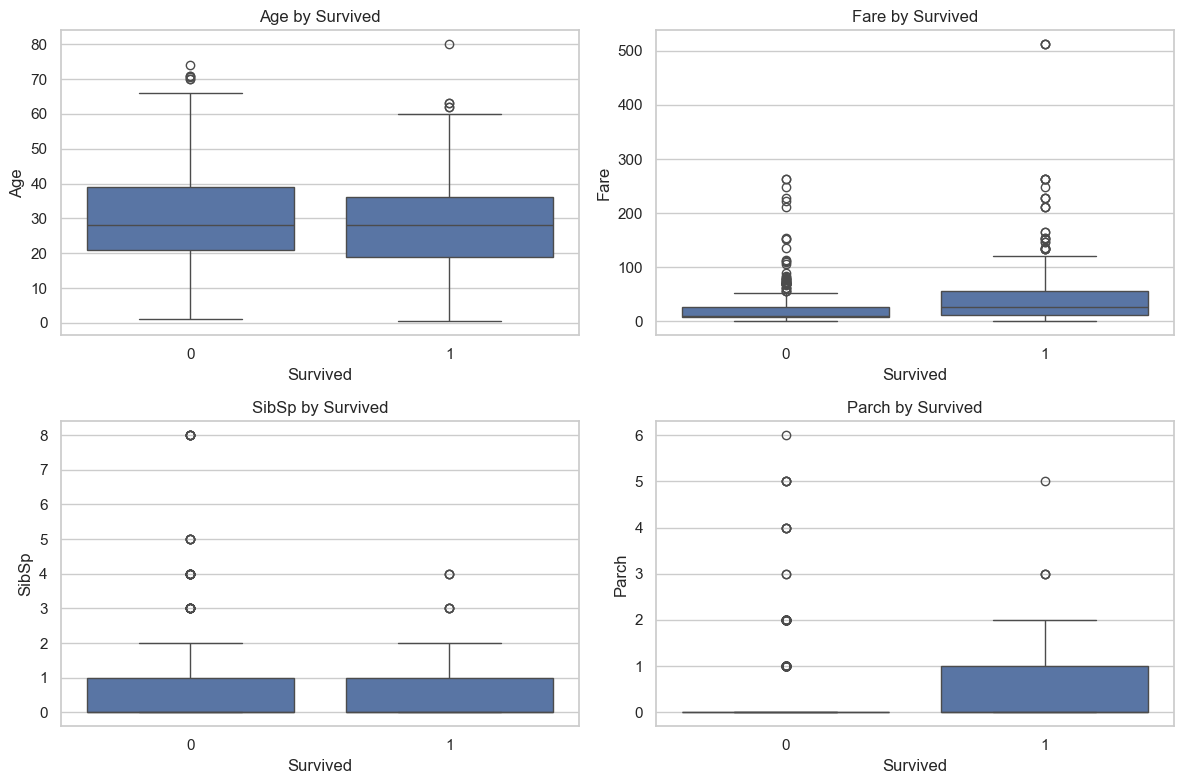

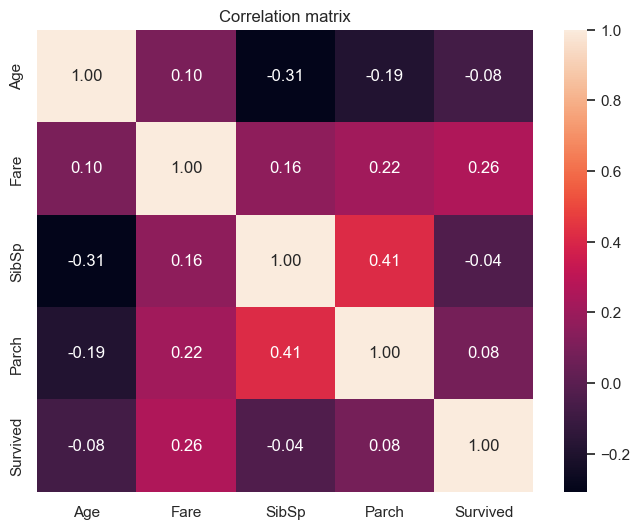

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Histograms for key numeric columns
num_cols = ["Age", "Fare", "SibSp", "Parch"]
train_df[num_cols].hist(figsize=(10,6)); plt.tight_layout()

# Boxplots: survival vs. numeric features
fig, axs = plt.subplots(2, 2, figsize=(12,8))
for ax, col in zip(axs.ravel(), num_cols):
    sns.boxplot(data=train_df, x="Survived", y=col, ax=ax)
    ax.set_title(f"{col} by Survived")
plt.tight_layout()

# Correlation heat‑map
plt.figure(figsize=(8,6))
sns.heatmap(train_df[num_cols + ["Survived"]].corr(), annot=True, fmt=".2f")
plt.title("Correlation matrix"); plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Features & target
X = train_df.drop(columns=["Survived", "PassengerId", "Name", "Ticket", "Cabin"])
y = train_df["Survived"]

# Numerical & categorical column lists
num_cols  = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols  = X.select_dtypes(include=["object"]).columns

# Pre‑processing pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg = Pipeline([
    ("prep", preprocessor),  # Make sure `preprocessor` is defined
    ("clf", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Sex', 'Embarked'], dtype='object'))])),
                ('clf', LogisticRegression(max_iter=1000))])

In [7]:
# Get names of encoded categorical features
ohe = log_reg.named_steps["prep"].named_transformers_["cat"].named_steps["encoder"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)

# Final combined feature names (numerical + encoded categorical)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get model coefficients
coeff = log_reg.named_steps["clf"].coef_[0]

# Create a sorted feature importance table
import pandas as pd
feat_imp = pd.Series(coeff, index=all_feature_names).sort_values(key=abs, ascending=False)
feat_imp.head(15)


Sex_female    1.310096
Sex_male     -1.308050
Pclass       -1.100291
Embarked_S   -0.347504
Embarked_Q    0.309690
SibSp        -0.248298
Parch        -0.080113
Embarked_C    0.039860
Age          -0.038969
Fare          0.002202
dtype: float64

In [8]:
# Coefficients sorted by absolute value
feat_imp = pd.Series(coeff, index=all_feature_names).sort_values(key=abs, ascending=False)
feat_imp.head(15).to_frame("Coefficient")


,Coefficient
Sex_female,1.310096
Sex_male,-1.308050
Pclass,-1.100291
Embarked_S,-0.347504
Embarked_Q,0.309690
SibSp,-0.248298
Parch,-0.080113
Embarked_C,0.039860
Age,-0.038969
Fare,0.002202


In [9]:
import pickle

# Save the entire pipeline (preprocessor + model)
with open("log_reg_titanic.pkl", "wb") as f:
    pickle.dump(log_reg, f)

print("Model saved as 'log_reg_titanic.pkl'")


Model saved as 'log_reg_titanic.pkl'
